# Importing Required Libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM as lstm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import sys 
from keras import regularizers
import os

Using TensorFlow backend.


# Plotting the audio file's waveform and its spectrogram


In [2]:
mylist= os.listdir('RawData')

##Plotting the audio file's waveform and its spectrogram

data, sampling_rate = librosa.load('RawData/03-02-01-01-01-02-16.wav')

In [3]:
type(mylist)


list

In [4]:
print(mylist[1800])


03-01-08-02-02-02-03.wav


In [5]:
print(mylist[0])


03-01-06-01-02-02-02.wav


In [6]:
print(mylist[400][6:-16])


02


In [7]:
len(mylist)

2451

Populating the interactive namespace from numpy and matplotlib


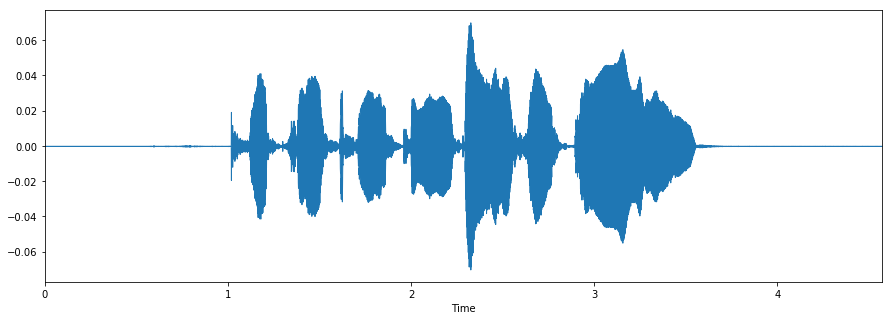

In [8]:
%pylab inline
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


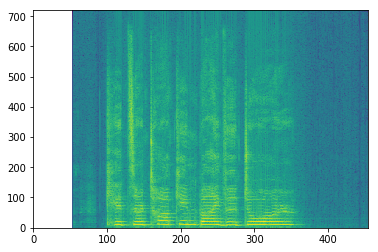

In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-02-16.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [10]:
sys.getsizeof(mylist)

21048

# Setting the labels 

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append(0)
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append(0)
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append(0)
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append(0)
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append(0)
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    
labels = pd.DataFrame(feeling_list)
print(feeling_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'male_sad', 'male_calm', 'male_calm', 'male_sad', 'male_fearful', 'male_angry', 'male_happy', 'male_happy', 'male_fearful', 'male_angry', 'male_calm', 'male_sad', 'male_sad', 'male_calm', 'male_calm', 'male_sad', 'male_sad', 'male_calm', 'male_fearful', 'male_angry', 'male_happy', 'male_happy', 'male_fearful', 'male_angry', 'male_happy', 'male_angry', 'male_fearful', 'male_fearful', 'male_angry', 'male_happy', 'male_happy', 'male_angry', 'male_fearful', 'male_angry', 'male_fearful', 'male_happy', 'male_sad', 'male_calm', 'male_calm', 'male_sad', 'male_sad', 'male_calm', 'male_calm', 'male_sad', 'male_happy', 'male_angry', 'male_fearful', 'male_angry', 'male_fearful', 'male_happy', 'male_fearful', 'male_angry', 'male_happy', 'male_happy', 'male_fearful', 'male_angry', 'male_calm', 'male_sad', 'male_sad', 'male_calm', 'male_calm', 'male_sa

In [12]:
labels = pd.DataFrame(feeling_list)
labels[:10]


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


# Getting the features of audio files using librosa


In [13]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X,
                                            sr=sample_rate,
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [14]:
df[:5]



,feature
0,"[-55.34954327651833, -55.58530507200249, -56.9..."
1,"[-55.0745316498102, -55.0745316498102, -55.074..."
2,"[-55.677100041008956, -55.42473315532577, -55...."
3,"[-49.55359492900165, -47.61808514016757, -47.4..."
4,"[-54.38846877583966, -54.38846877583966, -54.3..."


In [18]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df3.head()
X = df3.values[:,:]
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
x= scaler.transform(X)
df3 = pd.DataFrame(x)


In [19]:
newdf = pd.concat([df3,labels], axis=1)


In [20]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})


In [21]:
rnewdf[:5]


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-0.162075,-0.214624,-0.383728,-0.355529,-0.369696,-0.257886,-0.243470,-0.298531,-0.224796,-0.037247,...,-1.544957,-1.540614,-1.510135,-1.323533,-1.338774,-1.457034,-1.152835,-1.010247,-1.070735,0
1,-0.127910,-0.150278,-0.147572,-0.150204,-0.151893,-0.158991,-0.161801,-0.163018,-0.171470,-0.180673,...,0.223145,0.183204,0.043252,-0.030300,0.025972,-0.043901,0.006618,-0.368065,-0.472696,0
2,-0.202768,-0.194396,-0.168983,-0.056093,0.259376,0.370541,0.242380,0.081816,0.258744,0.181752,...,0.270693,0.191011,0.233269,0.311465,0.155172,-0.147912,-0.081559,1.111914,1.319402,0
3,0.557965,0.789061,0.827662,0.661347,0.474671,0.495746,0.439003,0.496290,0.665699,0.777029,...,-0.127080,-0.047359,-0.127495,-0.012131,-0.116948,-0.043073,-0.090083,0.191747,0.505453,0
4,-0.042680,-0.063850,-0.060316,-0.062557,-0.064507,-0.071951,-0.075427,-0.076924,-0.085223,-0.094520,...,-0.535184,-0.471787,-0.582975,-0.542937,-0.422488,-0.489371,-0.613411,-0.882764,-0.972751,0


In [22]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)

rnewdf=rnewdf.fillna(0)
rnewdf.shape

(1880, 217)

In [23]:

rnewdf=rnewdf.fillna(0)
rnewdf = rnewdf[rnewdf.iloc[:,-1]!=0]



# dividing the data into test and train


In [24]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [25]:
train[250:260]


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1393,0.309147,0.292919,0.299869,0.299246,0.296220,0.287347,0.281118,0.278465,0.270800,0.261114,...,1.248058,1.236386,1.258135,1.288914,1.307975,1.324738,1.293603,0.948559,0.831382,male_happy
959,-0.644788,-0.771774,-0.668083,-0.521319,-0.479461,-0.434316,-0.667335,-0.735149,-0.432807,-0.359495,...,0.966075,0.856465,0.691503,0.672754,0.599500,0.436025,0.307578,0.038856,-0.144571,male_angry
1628,0.281981,0.269258,0.322712,0.340486,0.382689,0.372060,0.008662,-0.011764,0.047692,0.078151,...,1.766368,1.551682,1.383904,1.396716,1.326355,1.195519,1.182196,1.373571,1.317378,male_happy
1171,0.808534,0.693240,0.564485,0.617130,0.552847,0.690132,0.624857,0.548606,0.536348,0.465618,...,-0.661847,-0.669383,-0.616026,-0.497930,-0.540238,-0.689043,-0.709060,-0.884686,-0.886810,male_calm
66,-1.511954,-1.553765,-1.564497,-1.573492,-1.570948,-1.480210,-0.998816,-0.721807,-0.521394,-0.542233,...,-0.305197,-0.223312,-0.197750,-0.360965,-0.359356,-0.254840,-0.160183,-0.426552,-0.384728,male_sad
1847,-1.519014,-1.621785,-1.707948,-1.816953,-1.755101,-1.779088,-1.804829,-1.763943,-1.812712,-1.770106,...,0.284271,0.297413,0.367557,0.469368,0.506415,0.492174,0.449007,0.733868,0.757848,male_calm
72,0.206891,0.130834,0.013040,0.198740,0.277937,0.323900,0.294119,0.297865,0.155504,0.280083,...,0.880929,1.004185,0.965087,1.013683,1.106739,1.127859,1.169751,1.028088,0.995064,male_fearful
1449,0.017700,-0.143675,-0.201460,-0.295097,-0.351033,-0.350187,-0.599215,-0.505570,-0.585671,-0.576243,...,0.225855,0.257567,0.380939,0.334974,0.360224,0.430046,0.351212,-0.044171,-0.117414,male_sad
1649,-1.906453,-1.984592,-1.999449,-2.010398,-2.006554,-2.006306,-1.963392,-1.990242,-1.814729,-1.810311,...,-0.949913,-0.973962,-0.757511,-0.622055,-0.649054,-0.632285,-0.686058,-0.642107,-0.787050,male_calm
579,-0.567507,-0.672101,-1.033017,-1.074423,-1.204576,-1.315575,-1.231044,-1.674909,-2.486600,-2.254418,...,-1.031766,-1.000753,-0.867828,-0.897709,-1.255434,-1.115591,-0.863938,-0.994488,-1.084744,male_calm


In [26]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]


In [27]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
y_train


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [29]:
X_train.shape


(761, 216)

In [30]:
## Changing dimension for  model

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [44]:
model = Sequential()

model.add(Conv1D(256, 15,padding='same',input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 15,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(16)))
model.add(Conv1D(128, 15,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Conv1D(64, 15,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Conv1D(32, 15,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [45]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 216, 256)          4096      
_________________________________________________________________
activation_19 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 216, 128)          491648    
_________________________________________________________________
activation_20 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 128)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 13, 128)           245888    
__________

In [46]:
model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])


In [47]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))


Train on 761 samples, validate on 199 samples
Epoch 1/200
761/761 [==============================] - 7s 9ms/step - loss: 1.6092 - acc: 0.2142 - val_loss: 1.6023 - val_acc: 0.2211
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 1.5981 - acc: 0.2181 - val_loss: 1.5960 - val_acc: 0.2663
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 1.5920 - acc: 0.2365 - val_loss: 1.5895 - val_acc: 0.3015
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 1.5848 - acc: 0.2746 - val_loss: 1.5822 - val_acc: 0.3015
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 1.5816 - acc: 0.2365 - val_loss: 1.5743 - val_acc: 0.3166
Epoch 6/200
761/761 [==============================] - 6s 8ms/step - loss: 1.5695 - acc: 0.2470 - val_loss: 1.5653 - val_acc: 0.3266
Epoch 7/200
761/761 [==============================] - 6s 8ms/step - loss: 1.5592 - acc: 0.2838 - val_loss: 1.5556 - val_acc: 0.3216
Epoch 8/200
761/761 [==

Epoch 62/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3189 - acc: 0.4336 - val_loss: 1.3980 - val_acc: 0.3769
Epoch 63/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3306 - acc: 0.4047 - val_loss: 1.3965 - val_acc: 0.3819
Epoch 64/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3218 - acc: 0.4297 - val_loss: 1.3980 - val_acc: 0.4020
Epoch 65/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3034 - acc: 0.4560 - val_loss: 1.3939 - val_acc: 0.3970
Epoch 66/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3154 - acc: 0.4244 - val_loss: 1.3910 - val_acc: 0.4020
Epoch 67/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3245 - acc: 0.4271 - val_loss: 1.3894 - val_acc: 0.3970
Epoch 68/200
761/761 [==============================] - 6s 8ms/step - loss: 1.3215 - acc: 0.4258 - val_loss: 1.3889 - val_acc: 0.3970
Epoch 69/200
761/761 [==============================] - 6s 8ms

Epoch 123/200
761/761 [==============================] - 6s 8ms/step - loss: 1.1961 - acc: 0.4901 - val_loss: 1.3230 - val_acc: 0.4070
Epoch 124/200
761/761 [==============================] - 6s 8ms/step - loss: 1.2067 - acc: 0.4809 - val_loss: 1.3222 - val_acc: 0.4171
Epoch 125/200
761/761 [==============================] - 6s 8ms/step - loss: 1.1911 - acc: 0.4941 - val_loss: 1.3216 - val_acc: 0.4070
Epoch 126/200
761/761 [==============================] - 6s 8ms/step - loss: 1.2040 - acc: 0.4928 - val_loss: 1.3160 - val_acc: 0.4221
Epoch 127/200
761/761 [==============================] - 6s 8ms/step - loss: 1.1996 - acc: 0.4941 - val_loss: 1.3200 - val_acc: 0.4070
Epoch 128/200
761/761 [==============================] - 6s 8ms/step - loss: 1.1886 - acc: 0.4783 - val_loss: 1.3237 - val_acc: 0.4372
Epoch 129/200
761/761 [==============================] - 6s 8ms/step - loss: 1.1661 - acc: 0.5059 - val_loss: 1.3165 - val_acc: 0.4322
Epoch 130/200
761/761 [==============================] 

761/761 [==============================] - 6s 8ms/step - loss: 1.0913 - acc: 0.5572 - val_loss: 1.2629 - val_acc: 0.4774
Epoch 184/200
761/761 [==============================] - 6s 8ms/step - loss: 1.0638 - acc: 0.5690 - val_loss: 1.2536 - val_acc: 0.4925
Epoch 185/200
761/761 [==============================] - 6s 8ms/step - loss: 1.0731 - acc: 0.5769 - val_loss: 1.2577 - val_acc: 0.4724
Epoch 186/200
761/761 [==============================] - 6s 8ms/step - loss: 1.0908 - acc: 0.5453 - val_loss: 1.2640 - val_acc: 0.4874
Epoch 187/200
761/761 [==============================] - 6s 8ms/step - loss: 1.0804 - acc: 0.5480 - val_loss: 1.2616 - val_acc: 0.4774
Epoch 188/200
761/761 [==============================] - 6s 8ms/step - loss: 1.0848 - acc: 0.5611 - val_loss: 1.2548 - val_acc: 0.4925
Epoch 189/200
761/761 [==============================] - 7s 9ms/step - loss: 1.0858 - acc: 0.5585 - val_loss: 1.2588 - val_acc: 0.4874
Epoch 190/200
761/761 [==============================] - 7s 9ms/step 

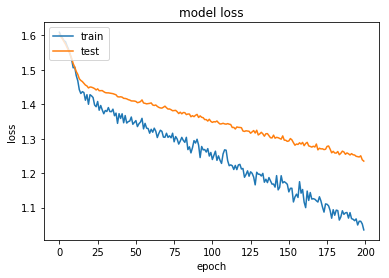

In [48]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
preds = loaded_model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

In [ ]:
preds


In [ ]:
preds1=preds.argmax(axis=1)


In [ ]:
preds1

In [ ]:
abc = preds1.astype(int).flatten()


In [ ]:
predictions = (lb.inverse_transform((abc)))


In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)


In [ ]:
finaldf[170:180]


In [ ]:
finaldf.groupby('actualvalues').count()


In [ ]:
finaldf.groupby('predictedvalues').count()


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)


In [ ]:
data, sampling_rate = librosa.load('output10.wav')


In [ ]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('laugh_5.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)


In [ ]:
livedf2 = livedf2.stack().to_frame().T


In [ ]:
livedf2


In [ ]:
twodim= np.expand_dims(livedf2, axis=2)


In [ ]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
livepreds


In [ ]:
livepreds1=livepreds.argmax(axis=1)


In [ ]:
liveabc = livepreds1.astype(int).flatten()


In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions